Notebook for the Dogs-vs-Cats competition

# 1. Import packages

In [1]:
import numpy as np
import pandas as pd

# Input data files are available in the "../input/" directory.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import os
import zipfile
import random
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shutil import copyfile
from os import getcwd
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Check to make sure that GPU is enable for the kernel
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2. Import data

Competition data comes in 2 sets:
* Train set: **25,000** images of dogs and cats
* Test set: **12,500** images of dogs and cats

They have in **different resolutions** also so we have to keep in consideration when preparing the training images.


In [3]:
# Extract train data to train folder
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip", "r") as z:
    z.extractall("dogs-vs-cats")

In [4]:
# Extract test data to test folder
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall("dogs-vs-cats")

In [5]:
print("Train size:", len(os.listdir('dogs-vs-cats/train/')))
print("Test size :", len(os.listdir('dogs-vs-cats/test1/')))

Train size: 25000
Test size : 12500


In [6]:
os.listdir('dogs-vs-cats/train/')[:10]

['cat.10632.jpg',
 'dog.634.jpg',
 'dog.10389.jpg',
 'cat.2490.jpg',
 'cat.2981.jpg',
 'cat.5794.jpg',
 'cat.7457.jpg',
 'cat.528.jpg',
 'cat.4363.jpg',
 'dog.7353.jpg']

In [7]:
os.listdir('dogs-vs-cats/test1/')[:10]

['3324.jpg',
 '3336.jpg',
 '552.jpg',
 '6123.jpg',
 '6180.jpg',
 '2022.jpg',
 '10024.jpg',
 '4931.jpg',
 '5829.jpg',
 '5360.jpg']

# 3. Data preparation

In [8]:
filenames = os.listdir("dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [10]:
df.head()

,filename,category
0,cat.10632.jpg,cat
1,dog.634.jpg,dog
2,dog.10389.jpg,dog
3,cat.2490.jpg,cat
4,cat.2981.jpg,cat


In [11]:
df.shape

(25000, 2)

The visualization below shows that images come in different shape, resolution and also subjects that are inside frame. Some have mutiple cats/dogs, some contain a cat/dog with people.

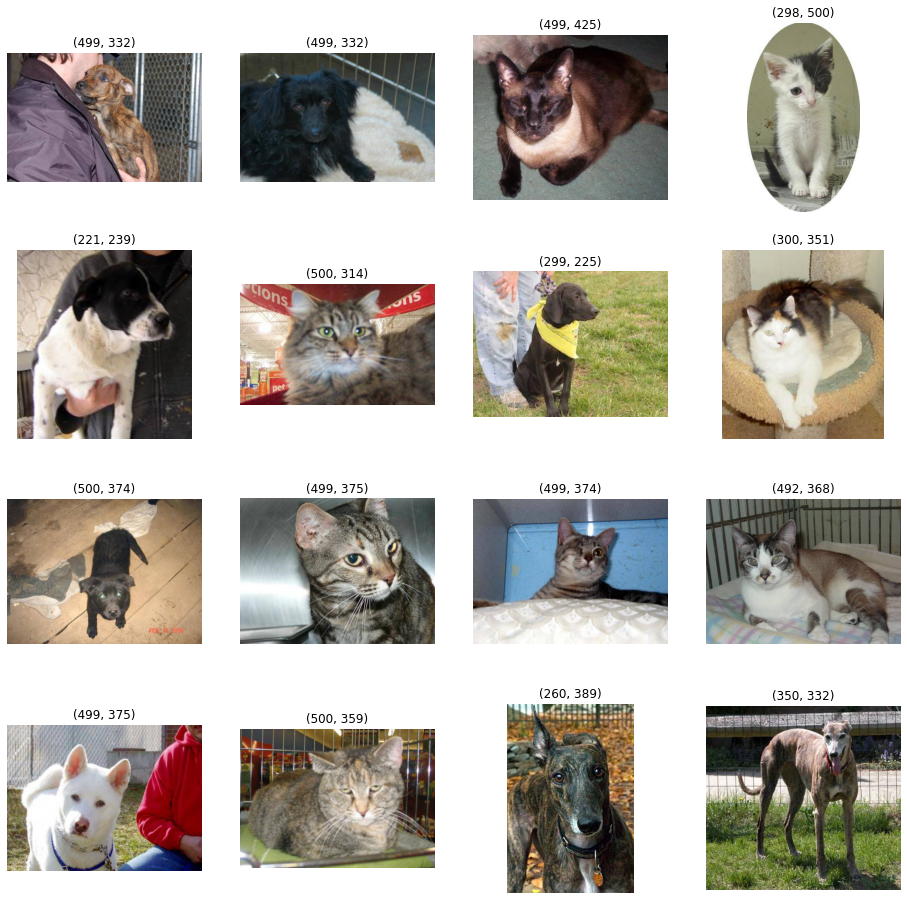

In [12]:
# Visualization for a better understanding of data distribution
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i in range(nrows * ncols):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    
    sample = random.choice(filenames)
    img = load_img("dogs-vs-cats/train/" + sample)
    
    sp.title.set_text(img.size)
    plt.imshow(img)

plt.show()

# 4. Model building

In [13]:
IMG_WIDTH=150
IMG_HEIGHT=150
IMG_SIZE=(IMG_WIDTH, IMG_HEIGHT)
IMG_CHANNELS=3

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0

In [15]:
model.compile(
    optimizer=RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
callbacks = [earlystop, learning_rate_reduction]

# 4. Data generators

In [17]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(20000, 2)
(5000, 2)


In [18]:
train_df.head()

,filename,category
0,cat.1968.jpg,cat
1,cat.3305.jpg,cat
2,cat.6798.jpg,cat
3,dog.8079.jpg,dog
4,cat.5954.jpg,cat


In [19]:
val_df.head()

,filename,category
0,cat.2879.jpg,cat
1,dog.6386.jpg,dog
2,dog.8664.jpg,dog
3,dog.1538.jpg,dog
4,dog.10716.jpg,dog


In [20]:
train_size = train_df.shape[0]
val_size = val_df.shape[0]
batch_size = 15

In [21]:
train_data_generator = ImageDataGenerator(rescale=1/255)
train_generator = train_data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory="dogs-vs-cats/train/",
    x_col='filename',
    y_col='category',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [22]:
val_data_generator = ImageDataGenerator(rescale=1/255)
val_generator = val_data_generator.flow_from_dataframe(
    dataframe=val_df,
    directory="dogs-vs-cats/train",
    x_col="filename",
    y_col="category",
    target_size=IMG_SIZE,
    class_mode="binary",
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# 5. Model training

The model seems a bit **overfitting** at the moment. We got quite high accuracy on **train set (0.9623)** but the **validation** accuracy is **hovering around 0.8** for most epochs.

In [23]:
epochs = 10
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_size//batch_size,
    steps_per_epoch=train_size//batch_size,
    callbacks=callbacks
)

Train for 1333 steps, validate for 333 steps
Epoch 1/10
1333/1333 [==============================] - 78s 59ms/step - loss: 0.6401 - accuracy: 0.6863 - val_loss: 0.4649 - val_accuracy: 0.7714
Epoch 2/10
1333/1333 [==============================] - 72s 54ms/step - loss: 0.4444 - accuracy: 0.7958 - val_loss: 1.0085 - val_accuracy: 0.5884
Epoch 3/10
1333/1333 [==============================] - 72s 54ms/step - loss: 0.3686 - accuracy: 0.8383 - val_loss: 0.4018 - val_accuracy: 0.8224
Epoch 4/10
1333/1333 [==============================] - 73s 54ms/step - loss: 0.3028 - accuracy: 0.8715 - val_loss: 0.9086 - val_accuracy: 0.6883
Epoch 5/10
1333/1333 [==============================] - 73s 55ms/step - loss: 0.2392 - accuracy: 0.9022 - val_loss: 0.4019 - val_accuracy: 0.8432
Epoch 6/10
1333/1333 [==============================] - 72s 54ms/step - loss: 0.1863 - accuracy: 0.9265 - val_loss: 0.7446 - val_accuracy: 0.7746
Epoch 7/10
1333/1333 [==============================] - 72s 54ms/step - loss: 0

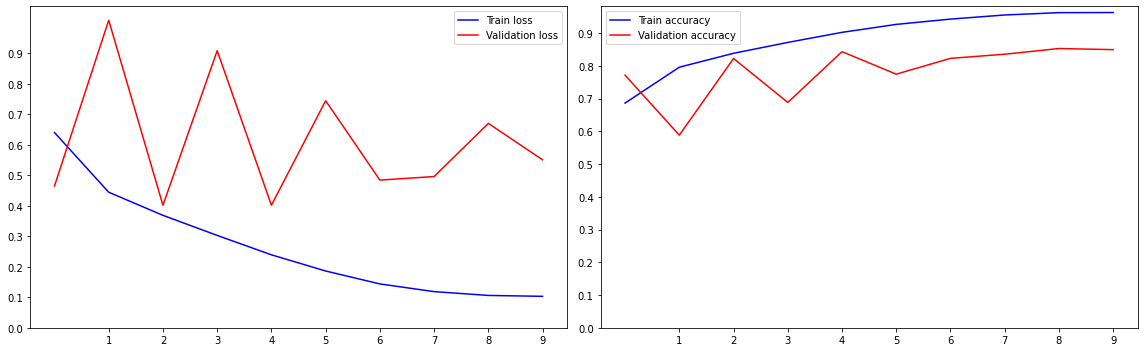

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.plot(history.history['loss'], color='b', label='Train loss')
ax1.plot(history.history['val_loss'], color='r', label='Validation loss')
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best')

ax2.plot(history.history['accuracy'], color='b', label='Train accuracy')
ax2.plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

# 6. Model saving

Just save model first and submit it.

In [25]:
model.save_weights("model.h5")

# 7. Predict for test data

In [26]:
test_filenames = os.listdir("dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [27]:
test_df.head()

,filename
0,3324.jpg
1,3336.jpg
2,552.jpg
3,6123.jpg
4,6180.jpg


In [28]:
test_data_generator = ImageDataGenerator(rescale=1/255)
test_generator = test_data_generator.flow_from_dataframe(
    test_df,
    "dogs-vs-cats/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [29]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [30]:
test_df['category'] = predict
test_df['category'] = test_df['category'].round()
test_df.head()

,filename,category
0,3324.jpg,0.0
1,3336.jpg,1.0
2,552.jpg,0.0
3,6123.jpg,0.0
4,6180.jpg,1.0


In [31]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df.head()

,filename,category
0,3324.jpg,cat
1,3336.jpg,dog
2,552.jpg,cat
3,6123.jpg,cat
4,6180.jpg,dog


In [32]:
test_df[test_df.category=='cat'].shape

(6401, 2)

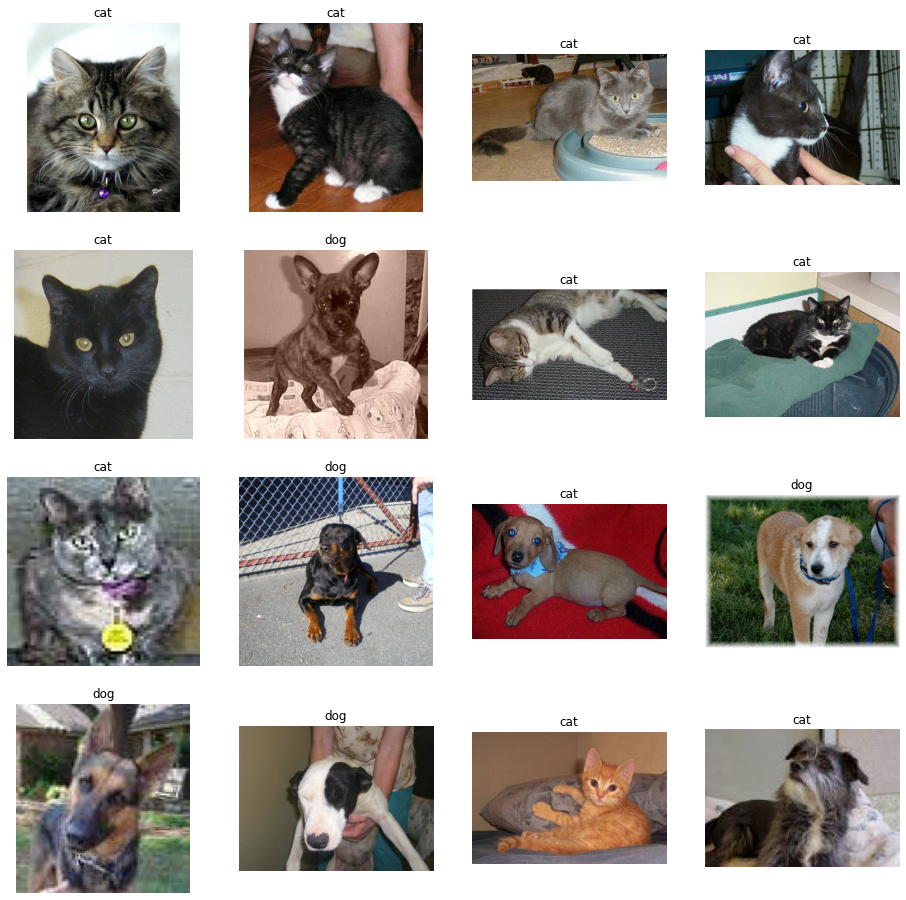

In [33]:
# Visualization for a better understanding of data distribution
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i in range(nrows * ncols):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    
    sample = random.choice(test_filenames)
    img = load_img("dogs-vs-cats/test1/" + sample)
    
    sp.title.set_text(str(test_df[test_df.filename==sample].reset_index().category[0]))
    plt.imshow(img)

plt.show()

In [34]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
test_df.head()

,filename,category
0,3324.jpg,0
1,3336.jpg,1
2,552.jpg,0
3,6123.jpg,0
4,6180.jpg,1


In [35]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('dogs-vs-cats/submission.csv', index=False)

In [36]:
submission_df.head()

,id,label
0,3324,0
1,3336,1
2,552,0
3,6123,0
4,6180,1
